In [1]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from PIL import Image
import os
import random

In [2]:
path_test = "flowers/"

In [3]:
CATEGORIES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
IMG_SIZE =200

In [4]:
#Image Augmentation
training = []
def createTrainingData():
  for category in CATEGORIES:
    path = os.path.join(path_test, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training.append([new_array, class_num])

createTrainingData()

In [5]:
random.shuffle(training)

In [6]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [7]:
X = X.astype('float32')
X /= 255
from keras.utils import np_utils
Y = np_utils.to_categorical(y, 5)
print(Y[100])
print(Y.shape)
print(X.shape)

[0. 0. 0. 0. 1.]
(4317, 5)
(4317, 200, 200, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [9]:
n = int(len(X_test)/2)
x_valid, y_valid = X_test[:n], y_test[:n]
x_test, y_test = X_test[n:], y_test[n:]

In [10]:
print(X_train.shape)
print(y_train.shape)

(3453, 200, 200, 3)
(3453, 5)


In [11]:
print(X_test.shape)
print(y_test.shape)

(864, 200, 200, 3)
(432, 5)


In [12]:
 x_valid.shape, y_valid.shape

((432, 200, 200, 3), (432, 5))

Label:  dandelion


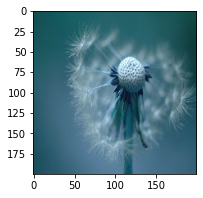

In [13]:
print('Label: ', CATEGORIES[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((X_train[7]));

In [14]:
def model():
    #model creation
    model = Sequential()

    #Adding layers
    model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    #CompilIng the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [15]:
#Saving the model
checkpointer = ModelCheckpoint(filepath='cnn_model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 198, 198, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 97, 97, 128)       0         
                                                        

In [17]:
history = model.fit(X_train, y_train, 
                    epochs=5, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/5

Epoch 1: val_loss improved from inf to 1.18817, saving model to cnn_model.hdf5
108/108 - 806s - loss: 1.3417 - accuracy: 0.4054 - val_loss: 1.1882 - val_accuracy: 0.4815 - lr: 0.0010 - 806s/epoch - 7s/step
Epoch 2/5

Epoch 2: val_loss improved from 1.18817 to 1.03196, saving model to cnn_model.hdf5
108/108 - 752s - loss: 1.0286 - accuracy: 0.5746 - val_loss: 1.0320 - val_accuracy: 0.6157 - lr: 0.0010 - 752s/epoch - 7s/step
Epoch 3/5

Epoch 3: val_loss improved from 1.03196 to 0.95012, saving model to cnn_model.hdf5
108/108 - 676s - loss: 0.9040 - accuracy: 0.6331 - val_loss: 0.9501 - val_accuracy: 0.6852 - lr: 0.0010 - 676s/epoch - 6s/step
Epoch 4/5

Epoch 4: val_loss improved from 0.95012 to 0.85736, saving model to cnn_model.hdf5
108/108 - 583s - loss: 0.8268 - accuracy: 0.6780 - val_loss: 0.8574 - val_accuracy: 0.6991 - lr: 0.0010 - 583s/epoch - 5s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.85736 to 0.83202, saving model to cnn_model.hdf5
108/108 - 568s - loss: 0.7

In [31]:



data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                
                                                
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),
                                 steps_per_epoch = len(X_train)//64, epochs=5, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

C:\Users\amirt\AppData\Local\Temp\ipykernel_10520\2477491839.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=64),


Epoch 1/5

Epoch 1: val_loss improved from 0.68668 to 0.67161, saving model to cnn_model.hdf5
53/53 - 687s - loss: 0.6332 - accuracy: 0.7628 - val_loss: 0.6716 - val_accuracy: 0.7593 - lr: 0.0010 - 687s/epoch - 13s/step
Epoch 2/5

Epoch 2: val_loss did not improve from 0.67161
53/53 - 709s - loss: 0.6391 - accuracy: 0.7607 - val_loss: 0.6899 - val_accuracy: 0.7338 - lr: 0.0010 - 709s/epoch - 13s/step
Epoch 3/5

Epoch 3: val_loss improved from 0.67161 to 0.65519, saving model to cnn_model.hdf5
53/53 - 825s - loss: 0.6129 - accuracy: 0.7651 - val_loss: 0.6552 - val_accuracy: 0.7639 - lr: 0.0010 - 825s/epoch - 16s/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.65519
53/53 - 490s - loss: 0.6226 - accuracy: 0.7666 - val_loss: 0.6737 - val_accuracy: 0.7569 - lr: 0.0010 - 490s/epoch - 9s/step
Epoch 5/5

Epoch 5: val_loss improved from 0.65519 to 0.64462, saving model to cnn_model.hdf5
53/53 - 536s - loss: 0.6126 - accuracy: 0.7693 - val_loss: 0.6446 - val_accuracy: 0.7616 - lr: 0.00

In [32]:
model.load_weights('cnn_model.hdf5')

In [33]:
#Test the model
score = model.evaluate(x_test, y_test)
score

14/14 [==============================] - 11s 752ms/step - loss: 0.5606 - accuracy: 0.7917


[0.5605892539024353, 0.7916666865348816]

In [34]:
score = model.evaluate(X_train, y_train)
score

108/108 [==============================] - 100s 924ms/step - loss: 0.5491 - accuracy: 0.8097


[0.549095869064331, 0.8097306489944458]

In [35]:
score = model.evaluate(x_valid, y_valid)
score

14/14 [==============================] - 13s 890ms/step - loss: 0.6446 - accuracy: 0.7616


[0.6446177363395691, 0.7615740895271301]

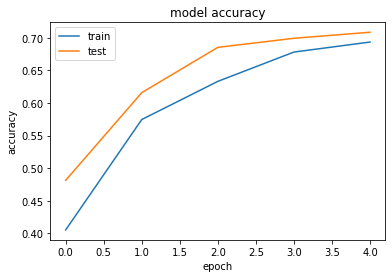

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

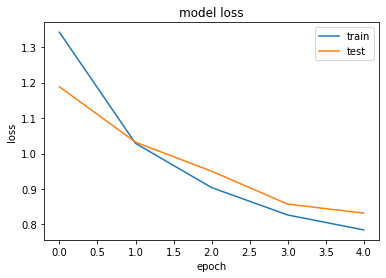

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
model.save('model.h5')

In [39]:
model1 = load_model('model.h5')

In [40]:
y_test_predict = model1.predict(x_test)

14/14 [==============================] - 13s 898ms/step


In [41]:
y_test_predict = np.argmax(y_test_predict,axis=1)

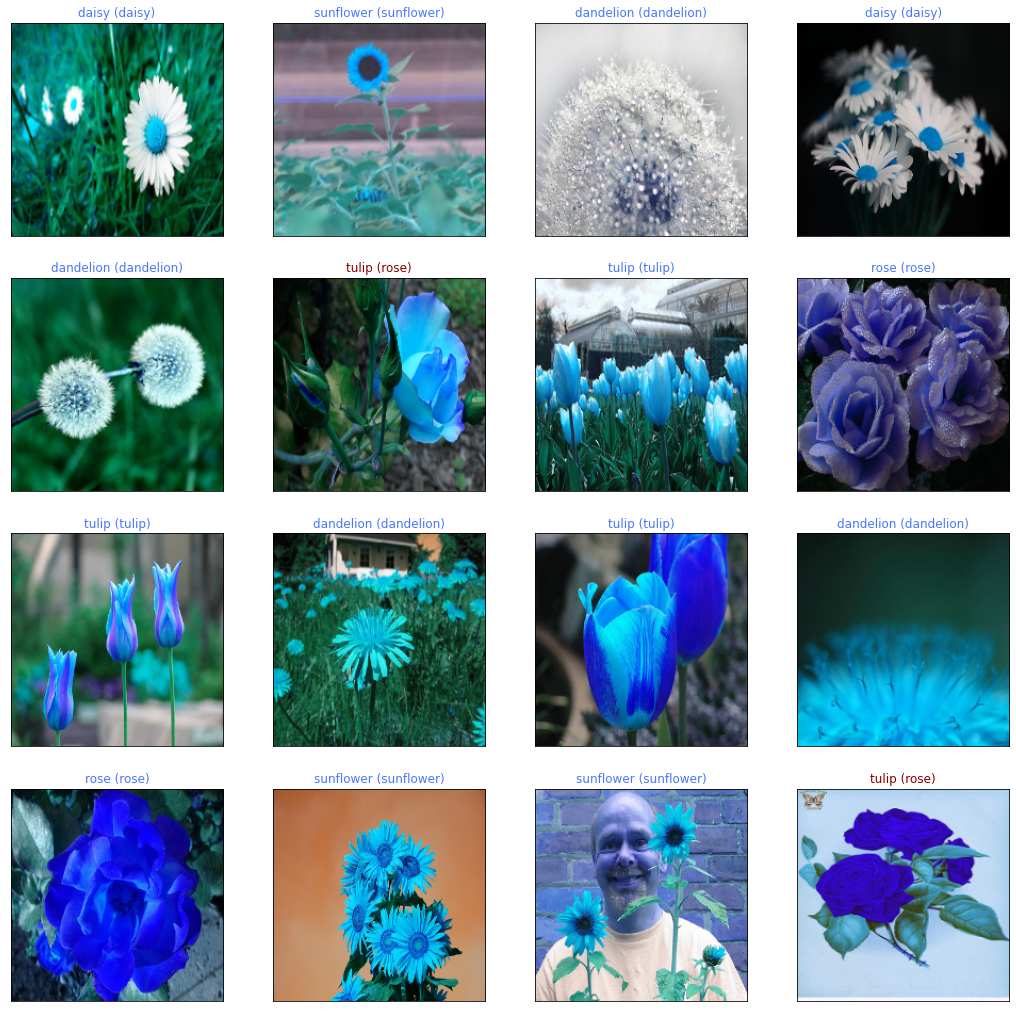

In [42]:


# Display true labels and predictions




fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(CATEGORIES[pred_idx], CATEGORIES[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))